# Segmenting and Clustering Neighbourhoods in Toronto

In this assignment, we will be exploring and clustering the neighbourhoods in Toronto.

This assignment comprises of three parts:

<a href='#part1'>Part 1 : </a> This part covers to gathering and cleaning up of the canada postal raw data like postal code, neighbourhood and borough. The result of this part is <a href='#part1-result'>provided here</a>.

<a href='#part2'>Part 2 : </a> This part covers to steps required to determine the latitude/longitude for each postal code. The result of this part is <a href='#part2-result'>provided here</a>.

<a href='#part3'>Part 3 : </a> This part covers to steps required to determine the clustering of neighbourhood in Toronoto using K-means . The result of this part is <a href='#part3-result'>provided here</a>.

Before we get data and start exploring it, lets import the required libraries

In [158]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from bs4 import BeautifulSoup

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


<a id='part1'></a>
As part of the data extraction process, the following steps covers the steps involved in gathering the Canada postal code details from Wikipedia.

In [80]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [81]:
##dfs = pd.read_html(url, header=0)[0]
##dfs.head()

html_doc = requests.get(url).text
soup = BeautifulSoup(html_doc, 'html.parser')

dfs = pd.read_html(str(soup.find_all('table')[0]),header=0)[0]
dfs.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [82]:
dfs = dfs[dfs.Borough != 'Not assigned']
dfs.head(10)

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.

In [171]:
dfs_unass_ngh = dfs.loc[dfs['Neighbourhood'] == 'Not assigned']
for index, row in dfs_unass_ngh.iterrows():
    dfs.loc[index]['Neighbourhood'] = dfs.loc[index]['Borough']

dfs.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


<a id='part1-result'></a>

More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma.

In [84]:
dfs_grouped= dfs.groupby(['Postcode','Borough'],as_index=False).agg(lambda x : x.sum() if x.dtype=='float64' else ' , '.join(x))
dfs_grouped.head(10)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge , Malvern"
1,M1C,Scarborough,"Highland Creek , Rouge Hill , Port Union"
2,M1E,Scarborough,"Guildwood , Morningside , West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park , Ionview , Kennedy Park"
7,M1L,Scarborough,"Clairlea , Golden Mile , Oakridge"
8,M1M,Scarborough,"Cliffcrest , Cliffside , Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff , Cliffside West"


The shape of the final and derived dataframe is,

In [85]:
dfs_grouped.shape

(103, 3)

Hence the first part of the assignment is complete.

-----------

<a id='part2'></a>

# Latitude and Longitude Assignment

First step is this part of the assignment is to determine the latitude and longitude.

Since the geocoder result is inoperative, the CSV file provided with the latitude/longitude informaiont is read and applied to the dataframe.

** Determine Latitude and Longtitude **

In [86]:
df_latlog = pd.read_csv('Geospatial_Coordinates.csv')
df_latlog.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


<a id='part2-result'></a>

In the next step, the appropriate latitude and longitude coordinates are applied to the dataframe based on the postal code.  

In [87]:
def determinelat(postcode):
    val = df_latlog.loc[df_latlog['Postal Code'] == postcode, 'Latitude'].values[0]
    return val

def determinelong(postcode):
    val = df_latlog.loc[df_latlog['Postal Code'] == postcode, 'Longitude'].values[0]
    return val

dfs_grouped['Latitude']=dfs_grouped['Postcode'].apply(lambda x:determinelat(x))
dfs_grouped['Longitude']=dfs_grouped['Postcode'].apply(lambda x:determinelong(x))
    
dfs_grouped.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge , Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek , Rouge Hill , Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park , Ionview , Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea , Golden Mile , Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest , Cliffside , Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff , Cliffside West",43.692657,-79.264848


<a id='part3'></a>

# Clustering Neighborhood in Toronto

Get the list of Toronoto neighbourhood. Looking for related neighbourhoods related to the Borough with the word 'Toronto'. Using the Foursquare API, the relevant venues for the Toronto releated neighbourhood is gathered. 

In [88]:
CLIENT_ID = 'DRPWW31K3DEPTJBDSRUUC50KH5BSWH44B2PDBSR05JYQJVQT' # your Foursquare ID
CLIENT_SECRET = '5ZCTWDN4CCYBQKSR0AAVZZ01ULCO2ERKCNNERVASGLFPOPSX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Function to explore the nearby venues based on the geo location provided.

In [89]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Extract only rows that has the Borough that contains the word 'Toronto'

In [90]:
toronto_data = dfs_grouped.loc[dfs_grouped['Borough'].str.contains('Toronto')]
toronto_data.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West , Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West , India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [91]:
toronto_venues = getNearbyVenues(toronto_data['Neighbourhood'],toronto_data['Latitude'],toronto_data['Longitude'],500)

The Beaches
The Danforth West , Riverdale
The Beaches West , India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park , Summerhill East
Deer Park , Forest Hill SE , Rathnelly , South Hill , Summerhill West
Rosedale
Cabbagetown , St. James Town
Church and Wellesley
Harbourfront , Regent Park
Ryerson , Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide , King , Richmond
Harbourfront East , Toronto Islands , Union Station
Design Exchange , Toronto Dominion Centre
Commerce Court , Victoria Hotel
Roselawn
Forest Hill North , Forest Hill West
The Annex , North Midtown , Yorkville
Harbord , University of Toronto
Chinatown , Grange Park , Kensington Market
CN Tower , Bathurst Quay , Island airport , Harbourfront West , King and Spadina , Railway Lands , South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place , Underground city
Christie
Dovercourt Village , Dufferin
Little Portugal , Trinity
Brockton , Exhibition Place ,

Following are the list of Toronto related venues.

In [177]:
print(toronto_venues.shape)
toronto_venues.head()

(1708, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
1,The Beaches,43.676357,-79.293031,Starbucks,43.678798,-79.298045,Coffee Shop
2,The Beaches,43.676357,-79.293031,Guru Raghavendra Ji,43.680187,-79.292337,Astrologer
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Beaches,43.676357,-79.293031,Skaut Design,43.680344,-79.290540,Furniture / Home Store


How many venues are being returned for each neihgbourhood ?


In [93]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide , King , Richmond",100,100,100,100,100,100
Berczy Park,54,54,54,54,54,54
"Brockton , Exhibition Place , Parkdale Village",19,19,19,19,19,19
Business reply mail Processing Centre969 Eastern,18,18,18,18,18,18
"CN Tower , Bathurst Quay , Island airport , Harbourfront West , King and Spadina , Railway Lands , South Niagara",14,14,14,14,14,14
"Cabbagetown , St. James Town",47,47,47,47,47,47
Central Bay Street,81,81,81,81,81,81
"Chinatown , Grange Park , Kensington Market",97,97,97,97,97,97
Christie,15,15,15,15,15,15


In [94]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 234 uniques categories.


** Analyze each heighbourhood **

In [95]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Examine the data frame size

In [96]:
toronto_onehot.shape

(1708, 235)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [97]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide , King , Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,0.000000,0.010000,0.010000,0.000000,0.030000,0.0,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.030000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.01,0.020000,0.000000,0.000000,0.020000,0.010000,0.00,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.010000,0.060000,0.000000,0.000000,0.00,0.000000,0.000000,0.020000,0.000000,0.020000,0.000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.00000

In [98]:
toronto_grouped.shape

(38, 235)

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [99]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [114]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide , King , Richmond",Coffee Shop,Café,Steakhouse,Thai Restaurant,American Restaurant,Hotel,Bar,Bakery,Restaurant,Gym
1,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Italian Restaurant,Bakery,Steakhouse,Seafood Restaurant,Farmers Market,Pub,Cheese Shop
2,"Brockton , Exhibition Place , Parkdale Village",Coffee Shop,Breakfast Spot,Café,Pet Store,Burrito Place,Stadium,Bar,Caribbean Restaurant,Furniture / Home Store,Italian Restaurant
3,Business reply mail Processing Centre969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Pizza Place,Park,Recording Studio,Restaurant,Burrito Place,Brewery,Skate Park
4,"CN Tower , Bathurst Quay , Island airport , Ha...",Airport Service,Airport Terminal,Airport Lounge,Boutique,Sculpture Garden,Plane,Harbor / Marina,Boat or Ferry,Airport Gate,Airport Food Court
5,"Cabbagetown , St. James Town",Coffee Shop,Restaurant,Park,Pizza Place,Café,Bakery,Indian Restaurant,Pub,Pharmacy,Italian Restaurant
6,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Bar,Burger Joint,Bubble Tea Shop,Café,Ice Cream Shop,Thai Restaurant,Middle Eastern Restaurant
7,"Chinatown , Grange Park , Kensington Market",Café,Bar,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Coffee Shop,Bakery,Dumpling Restaurant,Chinese Restaurant,Mexican Restaurant,Dessert Shop
8,Christie,Café,Grocery Store,Park,Nightclub,Convenience Store,Diner,Coffee Shop,Italian Restaurant,Baby Store,Restaurant
9,Church and Wellesley,Japanese Restaurant,Sushi Restaurant,Coffee Shop,Gay Bar,Restaurant,Burger Joint,Café,Men's Store,Mediterranean Restaurant,Fast Food Restaurant


## Cluster Neighborhoods

In [ ]:
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

Using Elbow method to determine the correct K value.

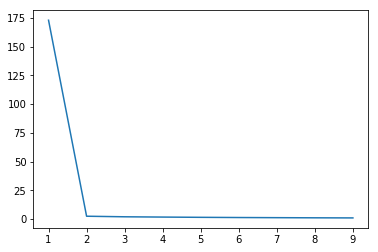

In [170]:
# Elbow criterion
def elbow_plot(data, maxK=10, seed_centroids=None):
    """
        parameters:
        - data: pandas DataFrame (data to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = {}
    for k in range(1, maxK):
        #print("k: ", k)
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(data)
            data["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
            data["clusters"] = kmeans.labels_
        # Inertia: Sum of distances of samples to their closest cluster center
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.show()
    return

elbow_plot(toronto_grouped_clustering, maxK=10)

Run *k*-means to cluster the neighborhood into 2 clusters.

In [178]:
# set number of clusters
kclusters = 2


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [162]:
toronto_merged = toronto_data

## create a new dataframe
#neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
#neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

#print(toronto_merged.head())
#print(neighborhoods_venues_sorted.head())
#neighborhoods_venues_sorted
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Neighborhood,Furniture / Home Store,Coffee Shop,Pub,Astrologer,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
41,M4K,East Toronto,"The Danforth West , Riverdale",43.679557,-79.352188,0,Greek Restaurant,Ice Cream Shop,Coffee Shop,Bookstore,Italian Restaurant,Cosmetics Shop,Brewery,Bubble Tea Shop,Café,Restaurant
42,M4L,East Toronto,"The Beaches West , India Bazaar",43.668999,-79.315572,0,Park,Sandwich Place,Fast Food Restaurant,Pub,Burger Joint,Board Shop,Burrito Place,Liquor Store,Light Rail Station,Fish & Chips Shop
43,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Coworking Space,Seafood Restaurant,Sandwich Place
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Park,Swim School,Dim Sum Restaurant,Bus Line,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


In [163]:
address = 'Toronto, Canada'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Toronto are 43.653963, -79.387207.


<a id='part3-result'></a>

The clustered is plotted in the map below,

In [175]:


# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

#### Cluster 1

In [165]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,The Beaches,0,Neighborhood,Furniture / Home Store,Coffee Shop,Pub,Astrologer,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
41,"The Danforth West , Riverdale",0,Greek Restaurant,Ice Cream Shop,Coffee Shop,Bookstore,Italian Restaurant,Cosmetics Shop,Brewery,Bubble Tea Shop,Café,Restaurant
42,"The Beaches West , India Bazaar",0,Park,Sandwich Place,Fast Food Restaurant,Pub,Burger Joint,Board Shop,Burrito Place,Liquor Store,Light Rail Station,Fish & Chips Shop
43,Studio District,0,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Coworking Space,Seafood Restaurant,Sandwich Place
45,Davisville North,0,Restaurant,Hotel,Sandwich Place,Burger Joint,Clothing Store,Park,Food & Drink Shop,Grocery Store,Breakfast Spot,Electronics Store
46,North Toronto West,0,Clothing Store,Coffee Shop,Sporting Goods Shop,Yoga Studio,Rental Car Location,Pet Store,Metro Station,Spa,Fast Food Restaurant,Mexican Restaurant
47,Davisville,0,Sandwich Place,Dessert Shop,Restaurant,Seafood Restaurant,Italian Restaurant,Sushi Restaurant,Pizza Place,Coffee Shop,Café,Farmers Market
48,"Moore Park , Summerhill East",0,Playground,Trail,Intersection,Yoga Studio,Discount Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
49,"Deer Park , Forest Hill SE , Rathnelly , South...",0,Coffee Shop,Light Rail Station,Pub,Fried Chicken Joint,Sports Bar,Pizza Place,Convenience Store,Vietnamese Restaurant,Sushi Restaurant,Bagel Shop
50,Rosedale,0,Park,Playground,Trail,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


In [179]:
#### Cluster 2

In [166]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Lawrence Park,1,Park,Swim School,Dim Sum Restaurant,Bus Line,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
52,Church and Wellesley,1,Japanese Restaurant,Sushi Restaurant,Coffee Shop,Gay Bar,Restaurant,Burger Joint,Café,Men's Store,Mediterranean Restaurant,Fast Food Restaurant
57,Central Bay Street,1,Coffee Shop,Italian Restaurant,Sandwich Place,Bar,Burger Joint,Bubble Tea Shop,Café,Ice Cream Shop,Thai Restaurant,Middle Eastern Restaurant
65,"The Annex , North Midtown , Yorkville",1,Coffee Shop,Café,Sandwich Place,Pizza Place,History Museum,Indian Restaurant,Pharmacy,Cosmetics Shop,Pub,Burger Joint
67,"Chinatown , Grange Park , Kensington Market",1,Café,Bar,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Coffee Shop,Bakery,Dumpling Restaurant,Chinese Restaurant,Mexican Restaurant,Dessert Shop


*** Observations ***

Based on the cluster data, my observation is that cluster 2 venues are more aligned for Asian community and cluster 1 is for non-Asian community(predominantly European culture).